# Chicago

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from docplex.mp.model import Model
import torch
import torch.optim as optim
import pickle
from scipy.stats import pearsonr
import networkx as nx

### Data processing 

In [ ]:
data_complaints_complaints = pd.read_csv('complaints-complaints.csv')
data_investigator = pd.read_csv('investigators.csv')

merged_data = pd.merge(data_investigator, data_complaints_complaints, on=['cr_id'])
merged_data['full name'] = merged_data['first_name'] + ' ' + merged_data['last_name']
merged_data['combined time'] = merged_data['incident_date'].astype(str) + ' ' + merged_data['incident_time']
features = ['cr_id', 'beat', 'full name', 'combined time']
df = merged_data[features]
df = df.dropna()
df['combined time'] = pd.to_datetime(df['combined time'], errors='coerce')
df.sort_values(by = 'combined time')
df = df[(df['combined time'] >= '2022-01-01') & (df['combined time'] <= '2022-12-31')]

print(len(df['full name'].unique()))

### Construct officers' actual pairing

In [ ]:
# each officer should have M+1 total connections (including self‐loop)
M = 8

# 3) Index officers
officers = sorted(df['full name'].unique())
idx = {name: i for i, name in enumerate(officers)}
n = len(officers)

potential = np.zeros((n, n), dtype=int)
np.fill_diagonal(potential, 1)
for _, group in df.groupby(['cr_id', 'beat', 'combined time']):
    names = group['full name'].unique()
    ids = [idx[name] for name in names]
    for i in ids:
        for j in ids:
            potential[i, j] = 1

mdl = Model(name='officer_adj')

alpha = mdl.binary_var_matrix(n, n, name='α')

for i in range(n):
    mdl.add_constraint(alpha[i, i] == 1, ctname=f"diag_{i}")

for i in range(n):
    mdl.add_constraint(mdl.sum(alpha[i, j] for j in range(n)) == M+1,
                       ctname=f"rowdeg_{i}")
for j in range(n):
    mdl.add_constraint(mdl.sum(alpha[i, j] for i in range(n)) == M+1,
                       ctname=f"coldeg_{j}")

for i in range(n):
    for j in range(i+1, n):
        mdl.add_constraint(alpha[i, j] == alpha[j, i],
                           ctname=f"sym_{i}_{j}")
        
sol = mdl.solve(log_output=False)
if sol is None:
    raise RuntimeError(f"No feasible adjacency for M={M}")

alpha_before = np.zeros((n, n), dtype=int)
for i in range(n):
    for j in range(n):
        alpha_before[i, j] = int(alpha[i, j].solution_value)

print("Officer index → name:")
for i, name in enumerate(officers):
    print(f"{i}: {name}")
print(f"\nAdjacency matrix shape: {alpha_before.shape}")
print(alpha_before)
print("\nRow sums:", alpha_before.sum(axis=1))
print("Col sums:", alpha_before.sum(axis=0))


In [ ]:
#Test the symmetry of the matrix
is_symmetric = np.array_equal(alpha_before, alpha_before.T)
print("Is alpha symmetric?  ", is_symmetric)

### Construct timestamps

In [ ]:
df['combined times'] = pd.to_datetime(df['combined time'])

earliest_timestamp = min(df['combined time'])
df['relative times in days'] = (df['combined time'] - earliest_timestamp).dt.total_seconds() / (24*60*60)
grouped = df.groupby('full name')['relative times in days'].apply(list)
timestamps_per_officer = grouped.to_dict()
timestamps = list(timestamps_per_officer.values())
for i in range(len(timestamps)):
    timestamps[i] = np.sort(timestamps[i])

In [ ]:
def parameter_estimation(alpha, events, epochs_num):
    np.random.seed(42)
    
    # Flatten into two 1D tensors: times (float) and marks (long)
    all_times = []
    all_marks = []
    for k, ev in enumerate(events):
        all_times.append(torch.tensor(ev, dtype=torch.double))
        all_marks.append(torch.full((len(ev),), k, dtype=torch.long))
    times_unsorted = torch.cat(all_times)        # shape (N,)
    marks_unsorted = torch.cat(all_marks)        # shape (N,)
    
    # sort by time
    times, order = torch.sort(times_unsorted)
    marks = marks_unsorted[order]
    
    # observation window
    T = int(max([max(timestamps[i]) for i in range(len(events))]))
    
    # known branching matrix α (as a NumPy array or list of lists)
    alpha_np = np.array(alpha)
    D = alpha_np.shape[0]

    
    # convert α to a torch tensor once
    alpha = torch.as_tensor(alpha_np, dtype=torch.double)
    
    # --- 2) Initialize parameters to estimate -------------------------------
    init_mu    = np.round(np.random.rand(D), 3)   
    init_theta = np.round(np.random.rand(D), 3)   
    init_omega = np.round(np.random.rand(D, D), 3) 
    
    # we work in the unconstrained space and exponentiate inside the loop
    mu_param    = torch.log(torch.tensor(init_mu,    dtype=torch.double)).requires_grad_()
    theta_param = torch.log(torch.tensor(init_theta,    dtype=torch.double)).requires_grad_()
    omega_param = torch.log(torch.tensor(init_omega,    dtype=torch.double)).requires_grad_()
    
    optimizer = optim.Adam([mu_param, theta_param, omega_param], lr=1e-6)
    
    # --- 3) Training loop ------------------------------------------------------
    
    dt = 0.1
    for epoch in range(epochs_num):
        optimizer.zero_grad()
    
        # enforce positivity
        mu_pos    = torch.exp(mu_param)           # shape (D,)
        theta_pos = torch.exp(theta_param)        # shape (D,)
        omega_pos = torch.exp(omega_param)    # shape (D,D)
    
        N = times.numel()
    
        # point‐process term: sum_i log λ_{mark_i}(time_i)
        dt_mat = times.unsqueeze(1) - times.unsqueeze(0)    # (N,N)
        causal = (dt_mat > 0).double()                      # mask past events
    
        # get indices for α, ω, θ
        mi = marks                                       # (N,)
        mj = marks.unsqueeze(0).expand(N, N)             # (N,N)
        mi_mat = mi.unsqueeze(1).expand(N, N)            # (N,N)
    
        alpha_ij = alpha[mi_mat, mj]                         # (N,N)
        omega_ij = omega_pos[mi_mat, mj]                     # (N,N)
        theta_i  = theta_pos[mi].unsqueeze(1)                # (N,1)
    
        kern = alpha_ij * theta_i * omega_ij * torch.exp(-omega_ij * dt_mat) * causal
        sum_kern = kern.sum(dim=1)                       # (N,)
    
        lam_i = mu_pos[mi] + sum_kern                      # (N,)
        logL1 = torch.log(lam_i).sum()
    
        # 3b) compensator term
        dtT = (T - times).unsqueeze(0)                   # (1,N)
        Aθ = alpha * theta_pos.unsqueeze(1)              # (D,D)
    
        Aθ_m = Aθ[:, marks]                              # (D,N)
        omega_m  = omega_pos[:, marks]                       # (D,N)
    
        term = Aθ_m * (1 - torch.exp(-omega_m * dtT))        # (D,N)
        sum_term = term.sum(dim=1)                       # (D,)
    
        intL = mu_pos * T + sum_term                     # (D,)
        logL2 = intL.sum()
    
        # negative log-likelihood
        nll = logL2 - logL1
        nll.backward()
        optimizer.step()
    
        #print(f'epochs = {epoch} NLL = {nll.item():.4f}')
        if epoch % 200 == 0:
            print(f"Epoch {epoch:4d}  NLL = {nll.item():.4f}")
    
    # --- 4) Extract estimates -------------------------------------------------
    
    mu_est    = torch.exp(mu_param).detach().numpy()
    theta_est = torch.exp(theta_param).detach().numpy()
    omega_est = torch.exp(omega_param).detach().numpy()
    
    return mu_est, theta_est, omega_est

In [ ]:
mu_est, theta_est, omega_est = parameter_estimation(alpha_before, timestamps, 10000)

### Compute stationary intensity

In [ ]:
T = int(max([max(timestamps[i]) for i in range(len(timestamps))]))
def intensity(events,  T, alpha, theta, omega, mu, dt = 0.1):
    nodes = len(events)
    t = np.arange(0, T, dt)
    alpha = np.asarray(alpha)
    omega = np.asarray(omega)
    theta = np.asarray(theta)
    mu = np.asarray(mu)
    #evs = [np.asarray(ev) for ev in events]
    lam = np.zeros((nodes, len(t)))

    for n in range(nodes):
        for i in range(len(t)):
            lam[n, i] = mu[n]
            for j in range(nodes):
                for k in range(len(events[j])):
                    if t[i] > events[j][k]:
                        lam[n, i] += alpha[n, j] * theta[j] * omega[n, j] * np.exp(-omega[n, j]*(t[i] - events[j][k]))
    return lam
intensity = intensity(timestamps,  T, alpha_before, theta_est, omega_est, mu_est, dt = 0.1)

In [ ]:
lam_stationary = [np.mean(intensity[i]) for i in range(len(intensity))]

### Optimize the network using CPLEX

In [ ]:
def cp(M, mu, theta):

    n = len(mu)
    # --- MODEL ---
    mdl = Model(name='hawkes_adj_opt')
    mdl.set_log_output(True)
    mdl.parameters.timelimit.set(8000)     # set timelimit

    
    # Decision vars
    alpha = {(i,j): mdl.binary_var(name=f"alpha_{i}_{j}")
             for i in range(n) for j in range(n)}    
    g     = {(i,j): mdl.continuous_var(lb=0, name=f"g_{i}_{j}")
             for i in range(n) for j in range(n)}
    
    # Diagonal ones
    for i in range(n):
        mdl.add_constraint(alpha[i,i] == 1, ctname=f"diag_{i}")
    
    # Degree constraints
    for i in range(n):
        mdl.add_constraint(mdl.sum(alpha[i,j] for j in range(n)) == M+1,
                           ctname=f"outdeg_{i}")
    for j in range(n):
        mdl.add_constraint(mdl.sum(alpha[i,j] for i in range(n)) == M+1,
                           ctname=f"indeg_{j}")
    
    # Indicator constraints for g_{ij} = alpha_{ij} * theta_j * λ̄_j
    #    where λ̄_j = mu[j] + sum_k g[j,k]
    for i in range(n):
        for j in range(n):
            # compute λ̄_j as a linear expr in the g-variables
            lam_bar_j = mu[j] + mdl.sum(g[j,k] for k in range(n))
            # if alpha=1, enforce g = theta_j * lambda_bar_j
            mdl.add_indicator(alpha[i,j], g[i,j] == theta[j] * lam_bar_j,
                              name=f"ind_on_{i}_{j}")
            # if alpha=0, enforce g=0
            mdl.add_indicator(alpha[i,j], g[i,j] == 0,
                             active_value=0, name=f"ind_off_{i}_{j}")

    # Symmetry: α[i,j] == α[j,i]
    for i in range(n):
        for j in range(i+1, n):
            mdl.add_constraint(alpha[i,j] == alpha[j,i],
                               ctname=f"sym_{i}_{j}")

    
    # Objective: minimize sum of all g_{ij}
    mdl.minimize(mu[i] + mdl.sum(g[i,j] for i in range(n) for j in range(n)))
    
    
    # Solve
    sol = mdl.solve()
    if sol is None:
        raise RuntimeError("No feasible solution found")

    g_sol     = np.array([[sol.get_value(g[i,j])
                       for j in range(n)]
                      for i in range(n)])
    
    # Extract optimized alpha matrix
    alpha_opt = [[int(alpha[i,j].solution_value) for j in range(n)]
                 for i in range(n)]
    alpha_opt = np.array(alpha_opt)
    return alpha_opt, g_sol
#rescale theta to preserve stationarity of the model
slack = 1e-6
target = (1 - slack) / M
scale  = target / max(theta_est)
theta_scaled = [t * scale for t in theta_est]
alpha_after, _ = cp(M, mu_est, theta_scaled)

### The different baseline methods

In [ ]:
#Standard Hawkes
def generate_hp_before(nodes, T, alpha, theta, omega, mu):

    mu = np.asarray(mu)
    alpha = np.asarray(alpha)
    omega = np.asarray(omega)
    theta = np.asarray(theta)

    #1. Generate immigrants
    N0 = np.random.poisson(mu.sum()*T)
    # Uniform times on [0, T] 
    imm_times = np.random.rand(N0)*T
    #Marks drawn with probability p(k) = mu / sum(mu)
    imm_marks = np.random.choice(nodes, size = N0, p = mu/mu.sum())
    #events = list of (times, marks)
    events = list(zip(imm_times, imm_marks))

    #2. Recursivly generate offspring
    cnt = 0
    while cnt < N0:
        t_parent, k_parent = events[cnt]
        #for each possible children type j
        for j in range(nodes):
            # mean number of children in type j = alpha[j, k_parent]*theta[j]
            m = np.random.poisson(alpha[j, k_parent]*theta[j])
            if m > 0:
                #draw m exponential delays with rate omega[j, k_parent]
                delays = np.random.exponential(1.0/(omega[j, k_parent] + 1e-08), size = m)
                for d in delays:
                    t_child = t_parent + d
                    if t_child < T:
                        events.append((t_child, j))

        cnt += 1

    #3. Sort the events and split by type 
    events.sort(key = lambda x: x[0])
    events_by_node = [[] for _ in range(nodes)]
    for t, k in events:
        events_by_node[k].append(t)

    return events_by_node

In [ ]:
#Hawkes MILP
def generate_hp_after(nodes, T, alpha, theta, omega, mu, lam_bar):

    mu = np.asarray(mu)
    alpha = np.asarray(alpha)
    omega = np.asarray(omega)
    theta = np.asarray(theta)

    #1. Generate immigrants
    N0 = np.random.poisson(mu.sum()*T)
    # Uniform times on [0, T] 
    imm_times = np.random.rand(N0)*T
    #Marks drawn with probability p(k) = mu / sum(mu)
    imm_marks = np.random.choice(nodes, size = N0, p = mu/mu.sum())
    #events = list of (times, marks)
    events = list(zip(imm_times, imm_marks))

    #2. Recursivly generate offspring
    cnt = 0
    while cnt < N0:
        t_parent, k_parent = events[cnt]
        #for each possible children type j
        for j in range(nodes):

    #incorporate optimized lam
            mean_offspring = alpha[j, k_parent] * theta[j] * lam_bar[j]
            if mean_offspring > 0:
                m = np.random.poisson(mean_offspring)
                if m > 0:
                    delays = np.random.exponential(1.0 / (omega[j, k_parent] + 1e-8), size=m)
                    for d in delays:
                        t_child = t_parent + d
                        if t_child < T:
                            events.append((t_child, j))
        cnt += 1

    #3. Sort the events and split by type 
    events.sort(key = lambda x: x[0])
    events_by_node = [[] for _ in range(nodes)]
    for t, k in events:
        events_by_node[k].append(t)

    return events_by_node

In [ ]:
#Greedy Heuristics
def greedy_influence_removal_iterative(alpha, events_by_node, theta, omega, M):
    alpha = np.asarray(alpha)
    omega = np.asarray(omega)
    theta = np.asarray(theta)
    
    n = alpha.shape[0]
    alpha_mod = alpha.copy()
    
    def compute_scores(alpha_mat):
        # score[(i,j)] = total influence of edge (i,j)
        scores = {}
        for i in range(n):
            for j in range(i+1, n):
                if alpha_mat[i,j] == 1:
                    s = 0.0
                    # j → i contributions
                    for t_j in events_by_node[j]:
                        for t_i in events_by_node[i]:
                            if t_j < t_i:
                                dt = t_i - t_j
                                s += theta[i] * omega[i,j] * np.exp(-omega[i,j] * dt)
                    # i → j contributions
                    for t_i in events_by_node[i]:
                        for t_j in events_by_node[j]:
                            if t_i < t_j:
                                dt = t_j - t_i
                                s += theta[j] * omega[j,i] * np.exp(-omega[j,i] * dt)
                    scores[(i,j)] = s
        return scores

    # Iteratively remove the edge with highest score
    for _ in range(M):
        scores = compute_scores(alpha_mod)
        if not scores:
            break
        # find edge with max score
        (i_best, j_best), _ = max(scores.items(), key=lambda kv: kv[1])
        # drop it
        alpha_mod[i_best, j_best] = 0
        alpha_mod[j_best, i_best] = 0
    
    return alpha_mod
alpha_greedy = greedy_influence_removal_iterative(alpha_before, timestamps, theta_est, omega_est, M)

In [ ]:
#Random permutation
def random_officer_reassignment(mu, theta, omega, alpha, events_by_node):
    D = len(mu)
    perm = np.random.permutation(D)

    # Permute mu and theta
    mu_perm = mu[perm]
    theta_perm = theta[perm]

    # Permute both axes of alpha and omega
    alpha_perm = alpha[perm][:, perm]
    omega_perm = omega[perm][:, perm]

    # Permute event traces
    events_by_node_perm = [[] for _ in range(D)]
    for old_idx, times in enumerate(events_by_node):
        new_idx = perm[old_idx]
        events_by_node_perm[new_idx] = times.copy()  # preserve times, relabel node
    
    return mu_perm, theta_perm, omega_perm, alpha_perm, events_by_node_perm
mu_r, theta_r, omega_r, alpha_r, events_r = random_officer_reassignment(mu_est, theta_est, omega_est, alpha_before, timestamps)

In [ ]:
#Rotation Policy
def simulate_rotation_policy(D, T, alpha, theta, omega, mu, delta_t):
    """
    Simulate a Hawkes process where every delta_t, officers are reassigned.
    
    Parameters
    ----------
    D : int - number of officers/nodes
    T : float - total time
    alpha, theta, omega, mu : MHP parameters
    delta_t : float - time interval for reassignment
    
    Returns
    -------
    events_by_node : list of lists - event times per officer
    """
    alpha = np.asarray(alpha)
    theta = np.asarray(theta)
    omega = np.asarray(omega)
    mu = np.asarray(mu)
    total_events = [[] for _ in range(D)]
    time_offset = 0.0

    while time_offset < T:
        dt = min(delta_t, T - time_offset)

        # permute officer labels
        perm = np.random.permutation(D)
        mu_p = mu[perm]
        theta_p = theta[perm]
        omega_p = omega[np.ix_(perm, perm)]
        alpha_p = alpha[np.ix_(perm, perm)]

        # simulate in this interval
        ev = generate_hp_before(D, dt, alpha_p, theta_p, omega_p, mu_p)

        # shift timestamps and assign back to fixed officer IDs
        for i in range(D):
            true_id = perm[i]
            shifted_events = [time_offset + t for t in ev[i]]
            total_events[true_id].extend(shifted_events)

        time_offset += dt

    # final sort
    for i in range(D):
        total_events[i].sort()
    return total_events

In [ ]:
nodes = len(df['full name'].unique())
T = int(max([max(timestamps[i]) for i in range(len(timestamps))]))

before_lenghts_array = []
after_lenghts_array = []
list_events_greedy = []
list_events_random_perm = []
rot = []

for sim in range(1000):
    events_before = generate_hp_before(nodes, T, alpha_before, theta_est, omega_est, mu_est)
    events_after = generate_hp_after(nodes, T, alpha_after, theta_est, omega_est, mu_est, lam_stationary)
    events_greedy = generate_hp_before(nodes, T, alpha_greedy, theta_est, omega_est, mu_est)
    events_r = generate_hp_before(nodes, T, alpha_r, theta_r, omega_r, mu_r)
    total_events_rot = simulate_rotation_policy(nodes, T, alpha_before, theta_est, omega_est, mu_est, 90)
    
    events_before = np.mean([len(events_before[i]) for i in range(nodes)])
    events_after = np.mean([len(events_after[i]) for i in range(nodes)])
    events_greedy = np.mean([len(events_greedy[i]) for i in range(nodes)])
    events_r = np.mean([len(events_r[i]) for i in range(nodes)])
    events_rotation = np.mean([len(i) for i in total_events_rot])
    

    
    before_lenghts_array.append(events_before)
    after_lenghts_array.append(events_after)
    list_events_greedy.append(events_greedy)
    list_events_random_perm.append(events_r)
    rot.append(events_rotation)

    
    if sim % 100 == 0:
        print('sim = ', sim)
        print(f'before = {events_before}, after = {events_after}, greedy = {events_greedy}, random officer perm = {events_r}, rotation = {events_rotation}')

print('standard = ' ,np.mean(before_lenghts_array))
print('hawkes milp = ', np.mean(after_lenghts_array)) 
print('greedy = ', np.mean(list_events_greedy))
print('random perm = ', np.mean(list_events_random_perm))  
print('rotation = ', np.mean(rot))

### Load the results in pickle files

In [15]:
#The code was already run and the results were stored in the following pickle files. You can run this snippet to 
#retreive the different model paramters and the expected number of events for each method (prform np.mean on each array)
with open('alpha_before.pkl', 'rb') as file:
    alpha_before = pickle.load(file)

with open('alpha_after.pkl', 'rb') as file:
    alpha_after = pickle.load(file)

with open('theta_est.pkl', 'rb') as file:
    theta_est = pickle.load(file)

with open('omega_est.pkl', 'rb') as file:
    omega_est = pickle.load(file)

with open('mu_est.pkl', 'rb') as file:
    mu_est = pickle.load(file)

with open('alpha_before.pkl', 'rb') as file:
   alpha_before = pickle.load(file)

with open('alpha_after.pkl', 'rb') as file:
    alpha_after = pickle.load(file)

with open('standard.pkl', 'rb') as file:
    standard = pickle.load(file)

with open('milp.pkl', 'rb') as file:
    milp = pickle.load(file)

with open('greedy.pkl', 'rb') as file:
    greedy = pickle.load(file)

with open('perm.pkl', 'rb') as file:
    random_perm = pickle.load(file)

with open('rot.pkl', 'rb') as file:
    rotation_policy = pickle.load(file)

np.mean(milp)

np.float64(620.2273315508021)

### Study assortativity

In [16]:
def theta_correlation(alpha, theta):
    """
    Compute Pearson correlation r between theta values
    over all undirected edges in alpha.
    """
    alpha = np.asarray(alpha)
    theta = np.asarray(theta)

    # Indices of upper-triangle edges (i<j)
    i_idx, j_idx = np.where(np.triu(alpha, k=1) == 1)

    # Corresponding theta values
    ti = theta[i_idx]
    tj = theta[j_idx]

    # Pearson r
    r, _ = pearsonr(ti, tj)
    return r


print(theta_correlation(alpha_before, theta_est), theta_correlation(alpha_after, theta_est))

0.016848765601472804 -0.7396475839565629


### Plot the network

In [11]:
def plot_network(alpha, target_node, filename = None):
    np.random.seed(42)
    # Ensure diagonal is 0
    np.fill_diagonal(alpha, 0)
    
    # Create graph from adjacency matrix
    G = nx.from_numpy_array(alpha)
    
    # Define node colors based on theta_estimated values
    node_colors = ['blue' if theta_est[i] < 0.5 else 'red' for i in range(len(theta_est))]
    
    # Compute node positions (same layout for both graphs for consistency)
    pos = nx.spring_layout(G)
    
    node_color=node_colors[target_node]
    
    # Get edges of the target node before optimization
    edges = [(target_node, neighbor) for neighbor in G.neighbors(target_node)]
    
    # Plot before optimization
    plt.figure(figsize=(16, 8))
    nx.draw(G, pos, node_color=node_colors, node_size=100, width=2, alpha=1)
    nx.draw_networkx_nodes(G, pos, nodelist=[target_node], node_color=node_color, edgecolors='black', node_size=300)  # Highlight node
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color= 'orange', width=3)  # Highlight edges
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

### Network highlight

In [12]:
def plot_highlight(alpha, target_node, filename = None, title = False):
    np.random.seed(42)

    # Ensure diagonal is 0
    np.fill_diagonal(alpha, 0)
    
    # Create graph from adjacency matrix
    G = nx.from_numpy_array(alpha)
    
    # Define node colors based on theta_estimated values
    node_colors = ['blue' if theta_est[i] < 0.5 else 'red' for i in range(len(theta_est))]
    
    # Compute node positions (consistent layout)
    pos = nx.spring_layout(G)

    
    # Find the immediate neighbors of the target
    neighbors = list(G.neighbors(target_node))
    
    # Build the subgraph containing only the target + its neighbors
    subgraph = G.subgraph([target_node] + neighbors)
    
    # Prepare highlighting lists
    highlight_nodes = [target_node] + neighbors
    highlight_colors = [node_colors[target_node]] + [node_colors[n] for n in neighbors]
    highlight_edges  = [(target_node, n) for n in neighbors]
    
    # Plot just the subgraph
    plt.figure(figsize=(8, 6))
    # draw the non‐highlighted part (none here, since subgraph is just the star)
    nx.draw_networkx_nodes(subgraph, pos, nodelist=highlight_nodes, node_color=highlight_colors, node_size=200)
    nx.draw_networkx_edges(subgraph, pos, edgelist=highlight_edges, edge_color='orange', width=3)
    # overlay the target node with a thick black circle
    nx.draw_networkx_nodes(subgraph, pos, nodelist=[target_node], node_color=[node_colors[target_node]], edgecolors='black', 
                           linewidths=3, node_size=300)
    if title:
        plt.title(title, y = -0.1, fontsize = 20)
    plt.axis('off')
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()


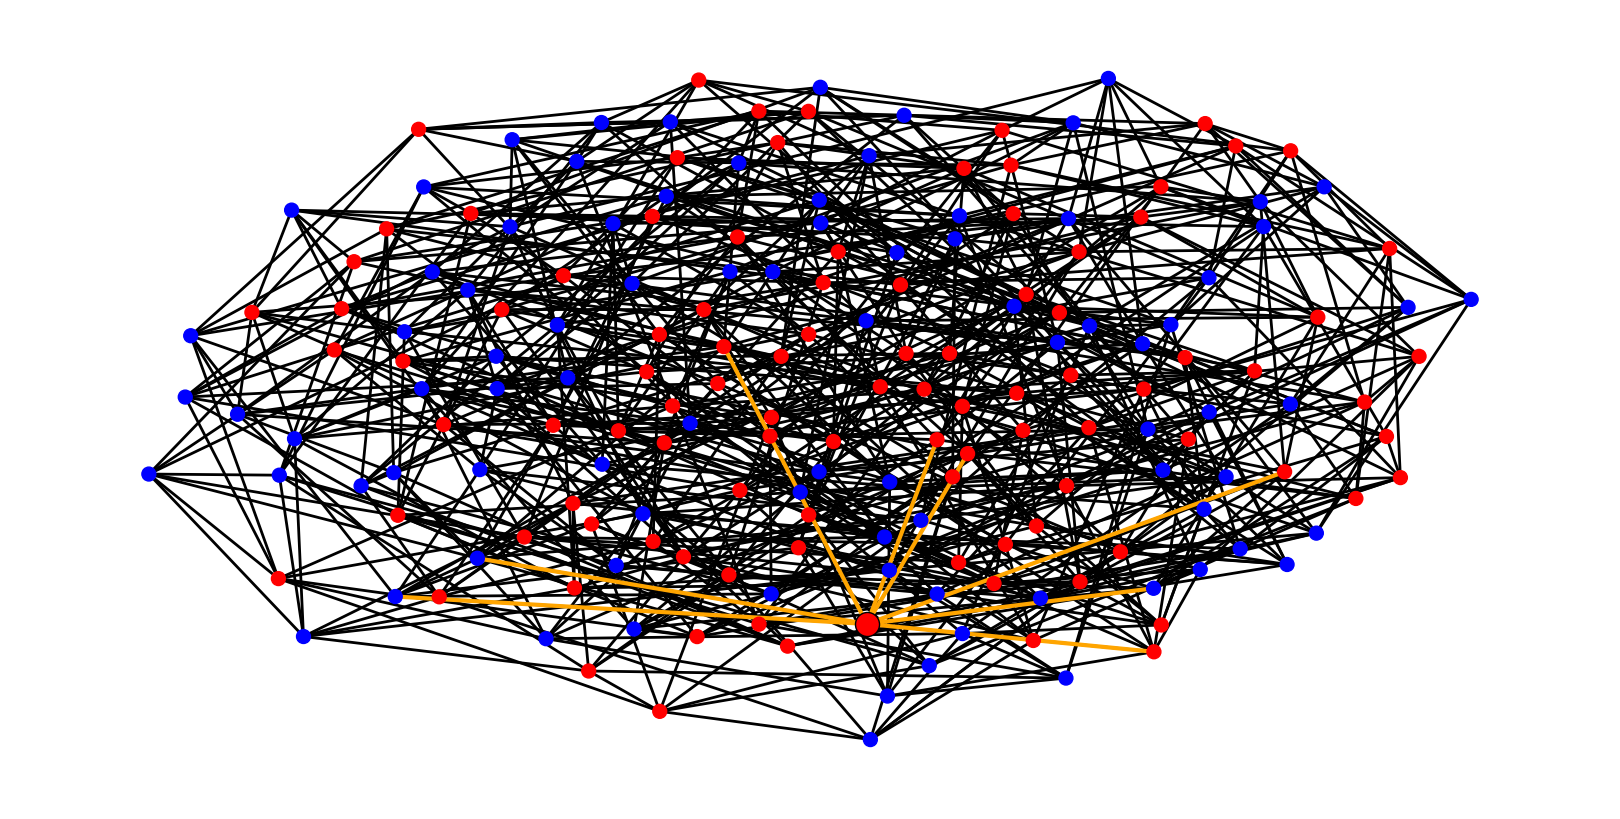

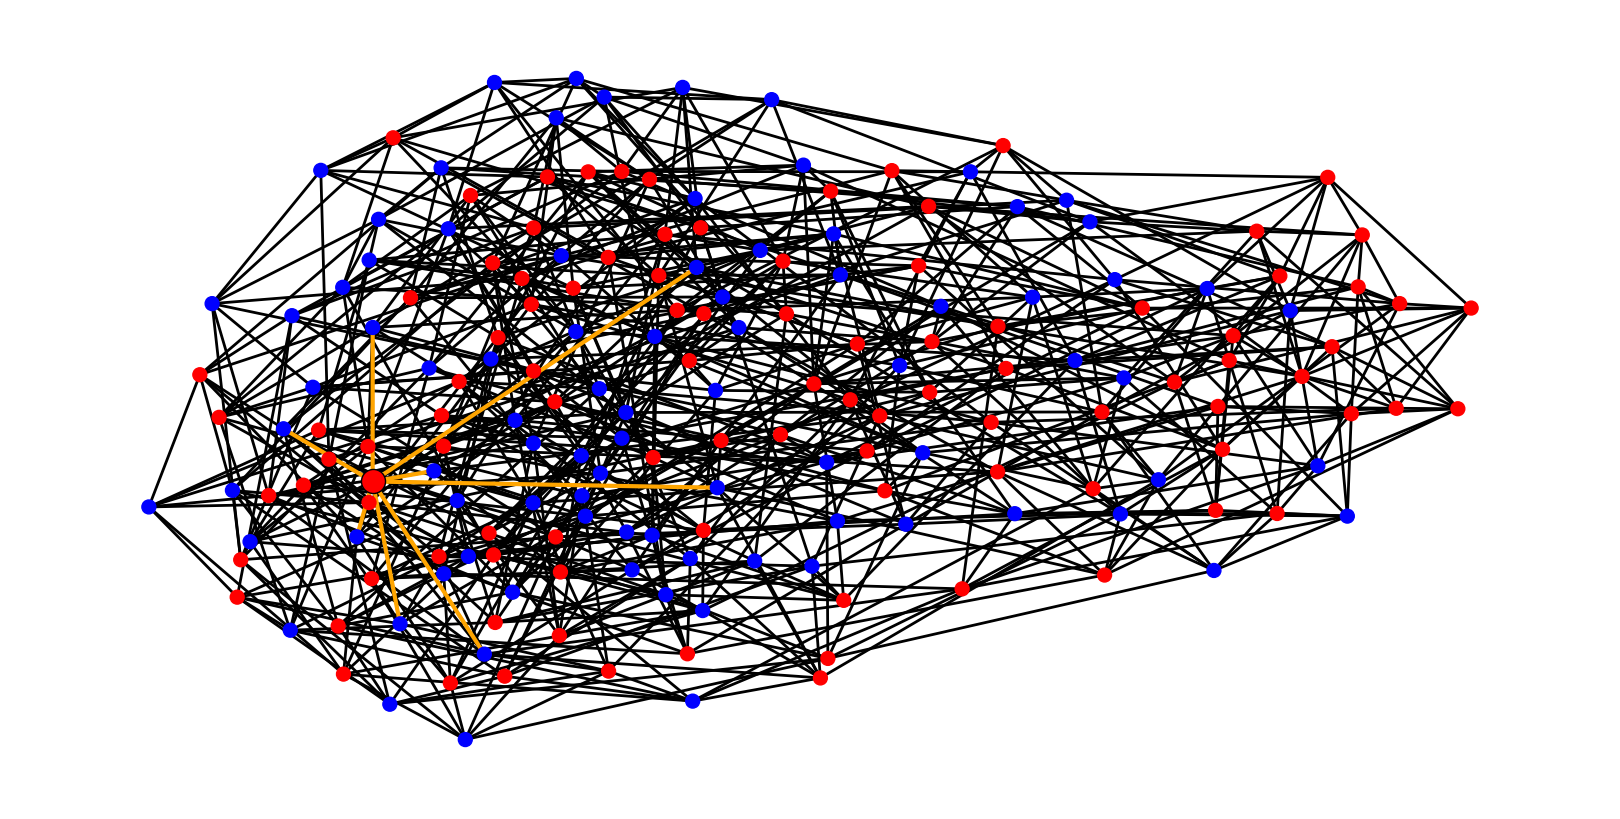

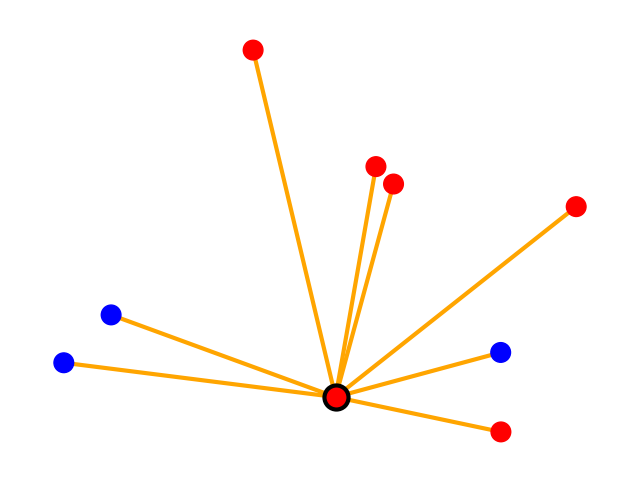

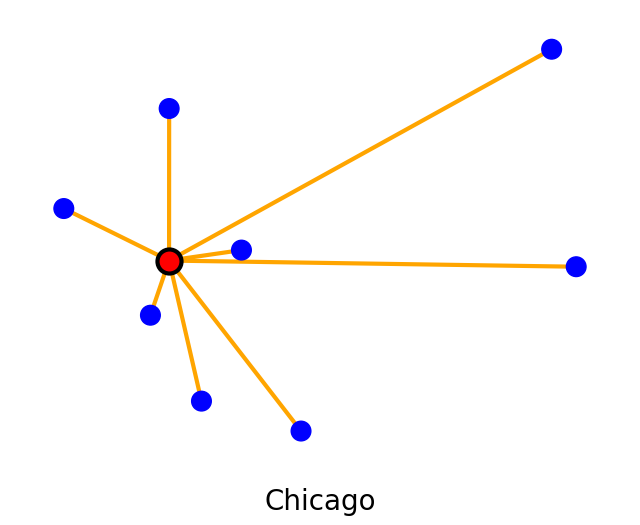

In [13]:
plot_network(alpha_before, 12, 'chicago_graph_before.eps')
plot_network(alpha_after, 12, 'chicago_graph_after.eps')
plot_highlight(alpha_before, 12, 'chicago_highlight_graph_before.eps')
plot_highlight(alpha_after, 12, 'chicago_highlight_graph_after.eps', 'Chicago')